In [1]:
%load_ext autoreload
%autoreload 2

import pmdarima as pm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from random import random
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import MaxAbsScaler
import warnings
import itertools
from sklearn.metrics import mean_absolute_error as mae
import random
from random import randint
from tqdm import tqdm
from sklearn.metrics import mean_squared_error as mse
import pickle
import datetime

import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

from mlopt.ACO import ACO
from mlopt.AGMLP_Residual import AGMLP_Residual
from mlopt.AGMLP_VR_Residual import AGMLP_VR_Residual
from mlopt.AGEnsemble_Residual import AGEnsemble_Residual
from mlopt.TimeSeriesUtils import *
import copy

warnings.filterwarnings("ignore")

# Data Correction Functions

In [2]:
def correct_apac(df_in, hour_range=(5,19)):
    
    df_apac = df_in.copy()
    df_apac = df_apac[df_apac.dia != "dia"]
    
    df_apac['Datetime']=pd.to_datetime(df_apac.dia.apply(str)+"/"+df_apac.mes.apply(str)+"/"+\
                                       df_apac.ano.apply(str), format="%d/%b/%Y")+\
                                       df_apac['hora(utc)'].apply(lambda x: datetime.timedelta(hours=int(x)))
    
    df_apac.drop_duplicates(subset="Datetime", inplace=True)
    
    inicio = datetime.datetime.strptime("01/"+str(df_apac.Datetime.iloc[0].month)+"/"+\
            str(df_apac.Datetime.iloc[0].year) + " "+ str(datetime.timedelta(hours=0)), "%d/%m/%Y %H:%M:%S")
    
    fim = df_apac.Datetime.iloc[-1]
    idx = pd.date_range(start=inicio,end=fim,freq='1H')
    
    #print(len(df_apac), len(df_apac.Datetime.unique()))
    
    df_apac = df_apac.set_index('Datetime').reindex(idx).reset_index().fillna(method='ffill')
    df_apac = df_apac[df_apac['hora(utc)'].isin(range(hour_range[0], hour_range[1]))]
    df_apac.drop(['ano','mes', 'dia', 'hora(utc)'],inplace=True,axis = 1)# drop duplicate infomation
        
    return df_apac

def correct_inmet(df_in, hour_range=(5,19)):
    
    df_inmet = df_in.copy()
    df_inmet.replace('////', np.nan, inplace=True)
    
    columns_to_numeric = list(set(df_inmet.columns) - set(["codigo_estacao","data","hora","planta"]))
        
    df_inmet[columns_to_numeric] = df_inmet[columns_to_numeric].apply(pd.to_numeric)
    df_inmet['Datetime']=pd.to_datetime(df_inmet.data, format="%d/%m/%Y")\
                    +df_inmet.hora.apply(lambda x: datetime.timedelta(hours=x))
    
    inicio = datetime.datetime.strptime("01/"+str(df_inmet.Datetime.iloc[0].month)+"/"+\
            str(df_inmet.Datetime.iloc[0].year) + " "+ str(datetime.timedelta(hours=0)), "%d/%m/%Y %H:%M:%S")
        
    fim = df_inmet.Datetime.iloc[-1]
    idx = pd.date_range(start=inicio,end=fim,freq='1H')

    df_inmet = df_inmet.set_index('Datetime').reindex(idx).reset_index().fillna(method='ffill')
    
    df_inmet = df_inmet[df_inmet['hora'].isin(range(hour_range[0], hour_range[1]))]
    df_inmet.drop(['data','hora'],inplace=True,axis = 1)# drop duplicate infomation
     
    return df_inmet

def correct_gen(df_in, hour_range=(5,19)):
    
    df_gen = df_in.copy()
    df_gen['HoraInt'] = df_gen.Hora.apply(lambda x: int(x.hour))
    df_gen = df_gen[df_gen['HoraInt'].isin(range(hour_range[0], hour_range[1]))]
    df_gen.drop(['HoraInt'], inplace=True, axis=1)
    
    return df_gen


# Load and Process Data

In [3]:
inmet_csv = './historical_data_BOMJESUSDALAPA.csv'
save_scaler = "florianopolis_MaxAbsScaler_gen.pckl"

df_inmet = pd.read_csv(inmet_csv, sep=',', encoding = "ISO-8859-1")

for c in df_inmet.columns:
    if (c not in ['data', 'hora']) and (df_inmet[c].dtype != "float64"):
        print(df_inmet[c].dtype)
        df_inmet[c] = df_inmet[c].apply(lambda x: float(str(x).replace(",","."))).fillna(method='ffill')
    
print(df_inmet.dtypes)

ultimos_dias = 15*24

posicao_final=len(df_inmet)
posicao_inicial=posicao_final - ultimos_dias

exog = df_inmet[['preciptacao_total_mm', 'temp_ar_bulbo_seco_c', 'umidade_relativa_prcnt',
                 'vento_velocidade_mps', 'vento_rajada_max_mps']].iloc[posicao_inicial:,:]

gen = df_inmet['radiacao_global_wpm2'].iloc[posicao_inicial:].values.reshape(-1,1)

print(df_inmet.iloc[posicao_inicial,:].data, df_inmet.iloc[posicao_inicial,:].hora,
      df_inmet.iloc[posicao_final-1,:].data,df_inmet.iloc[posicao_final-1,:].hora)

MaxAbsScaler_exog = MaxAbsScaler().fit(exog)
MaxAbsScaler_gen = MaxAbsScaler().fit(gen)

exog = MaxAbsScaler_exog.transform(exog)
gen = MaxAbsScaler_gen.transform(gen)[:,0]
pickle.dump(MaxAbsScaler_gen, open('resultados/MaxAbsScaler_gen.pckl', 'wb'))

object
object
object
object
object
object
object
object
object
object
object
object
object
int64
int64
int64
data                           object
hora                            int64
preciptacao_total_mm          float64
pressao_atm_mB                float64
pressao_atm_max_mB            float64
pressao_atm_min_mB            float64
radiacao_global_wpm2          float64
temp_ar_bulbo_seco_c          float64
temp_ponto_orvalho_c          float64
temp_max_c                    float64
temp_min_c                    float64
temp_orvalho_max_c            float64
temp_orvalor_min_c            float64
umidade_relativa_max_prcnt    float64
umidade_relativa_min_prcnt    float64
umidade_relativa_prcnt        float64
vento_dir_gr                  float64
vento_rajada_max_mps          float64
vento_velocidade_mps          float64
ano                           float64
mes                           float64
dia                           float64
dtype: object
2020/07/17 0 2020/07/31 23


FileNotFoundError: [Errno 2] No such file or directory: 'resultados/MaxAbsScaler_gen.pckl'

# SARIMAX 

## Auto ARIMA

In [5]:
pm.auto_arima(y=gen, X=exog, seasonal=True, m=24, maxiter=50, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[24] intercept   : AIC=inf, Time=2.89 sec
 ARIMA(0,0,0)(0,0,0)[24] intercept   : AIC=-92.428, Time=0.50 sec
 ARIMA(1,0,0)(1,0,0)[24] intercept   : AIC=-807.455, Time=3.87 sec
 ARIMA(0,0,1)(0,0,1)[24] intercept   : AIC=-545.838, Time=4.34 sec
 ARIMA(0,0,0)(0,0,0)[24]             : AIC=-60.479, Time=0.11 sec
 ARIMA(1,0,0)(0,0,0)[24] intercept   : AIC=-650.212, Time=0.43 sec
 ARIMA(1,0,0)(2,0,0)[24] intercept   : AIC=inf, Time=15.80 sec
 ARIMA(1,0,0)(1,0,1)[24] intercept   : AIC=inf, Time=4.20 sec
 ARIMA(1,0,0)(0,0,1)[24] intercept   : AIC=-737.426, Time=3.36 sec
 ARIMA(1,0,0)(2,0,1)[24] intercept   : AIC=inf, Time=15.27 sec
 ARIMA(0,0,0)(1,0,0)[24] intercept   : AIC=inf, Time=3.51 sec
 ARIMA(2,0,0)(1,0,0)[24] intercept   : AIC=-806.461, Time=4.53 sec
 ARIMA(1,0,1)(1,0,0)[24] intercept   : AIC=-805.127, Time=4.65 sec
 ARIMA(0,0,1)(1,0,0)[24] intercept   : AIC=-714.022, Time=3.74 sec
 ARIMA(2,0,1)(1,0,0)[24] intercept   : AIC=-

ARIMA(order=(3, 0, 2), scoring_args={}, seasonal_order=(2, 0, 2, 24),
      suppress_warnings=True, with_intercept=False)

In [6]:
mod = SARIMAX(endog=gen, exog=exog, order=(3, 0, 2), seasonal_order=(2, 0, 2, 24),
              enforce_stationarity=False,enforce_invertibility=False)
results = mod.fit(disp=True)
y_sarimax_auto = results.predict()
mape_autoarima = MAPE(y_sarimax_auto, gen)
print("AICc: {0}, Mape: {1}".format(results.aicc, mape_autoarima))

AICc: -825.1507882853775, Mape: 0.9518494576816882


## PSO-ACO Parametrization

In [7]:
p = [0, 1, 2, 3, 4]
d = [0, 1]
q = [0, 1, 2, 3]
sp = [0, 1, 2, 3]
sd = [0, 1]
sq = [0, 1, 2, 3]
s = [24, 48] #como são dados horarios...
# search Space, exog possibilities comes in the functions.
searchSpace = [p, d, q, sp, sd, sq, s]

options_PSO = {'n_particles':5,'n_iterations':3,'c1': 0.5, 'c2': 0.3, 'w': 0.9, 'k': 3, 'p': 2}
options_ACO = {'antNumber':3, 'antTours':3, 'alpha':2, 'beta':2, 'rho':0.5, 'Q':2}
exogColumns = ['preciptacao_total_mm', 'temp_ar_bulbo_seco_c', 'umidade_relativa_prcnt', 'vento_velocidade_mps', 'vento_rajada_max_mps']
y_sarimax_PSO_ACO = sarimax_PSO_ACO_search(endo_var=gen, exog_var_matrix=exog, searchSpace=copy.copy(searchSpace), 
                                   options_PSO=options_PSO, options_ACO=options_ACO, exogColumns=exogColumns, verbose=False)
                                   
mape_pso_aco = MAPE(y_sarimax_PSO_ACO, gen)
print("Mape: {0}".format(mape_pso_aco))

2021-02-09 23:08:28,838 - root - INFO - Original search Space: [[0, 1, 2, 3, 4], [0, 1], [0, 1, 2, 3], [0, 1, 2, 3], [0, 1], [0, 1, 2, 3], [0, 2]]
2021-02-09 23:08:28,838: INFO - Original search Space: [[0, 1, 2, 3, 4], [0, 1], [0, 1, 2, 3], [0, 1, 2, 3], [0, 1], [0, 1, 2, 3], [0, 2]]
2021-02-09 23:08:28,841 - root - INFO - search Space with Exog Possibilities: [[0, 1, 2, 3, 4], [0, 1], [0, 1, 2, 3], [0, 1, 2, 3], [0, 1], [0, 1, 2, 3], [0, 2], range(0, 32)]
2021-02-09 23:08:28,841: INFO - search Space with Exog Possibilities: [[0, 1, 2, 3, 4], [0, 1], [0, 1, 2, 3], [0, 1, 2, 3], [0, 1], [0, 1, 2, 3], [0, 2], range(0, 32)]
2021-02-09 23:08:28,843 - root - INFO - PSO boundaries: [0. 0. 0. 0. 0.] [3, 1, 3, 2, 31]
2021-02-09 23:08:28,843: INFO - PSO boundaries: [0. 0. 0. 0. 0.] [3, 1, 3, 2, 31]
2021-02-09 23:08:28,845 - root - INFO - 5
2021-02-09 23:08:28,845: INFO - 5
2021-02-09 23:08:29,424 - pyswarms.single.global_best - INFO - Optimize for 3 iters with {'c1': 0.5, 'c2': 0.5, 'w': 0.9, 

In [10]:
# A variável exógena então escolhida fica sendo apenas a temperatura. O que faz todo o sentido...
mod = SARIMAX(endog=gen, exog=exog[:,[1,2,3]], order=(1,0,0), seasonal_order=(2,0,2,24),
              enforce_stationarity=False,enforce_invertibility=False)
results = mod.fit(disp=True)
y_sarimax_PSO_ACO_hand = results.predict()
mape_pso_aco_hand = MAPE(y_sarimax_PSO_ACO_hand, gen)
print("AICc: {0}, Mape: {1}".format(results.aicc, mape_pso_aco_hand))

AICc: -831.8021789080478, Mape: 0.9233119200458031


## DUMP Sarimax

In [11]:
y_sarimax = y_sarimax_PSO_ACO_hand
dict_gen_ysarimax = {'generation':gen, 'y_sarimax':y_sarimax, 'data_inicial':df_inmet.data.iloc[posicao_inicial]}
pickle.dump(dict_gen_ysarimax, open('resultados/dict_gen_ysarimax.pckl', 'wb'))

## LOAD Sarimax

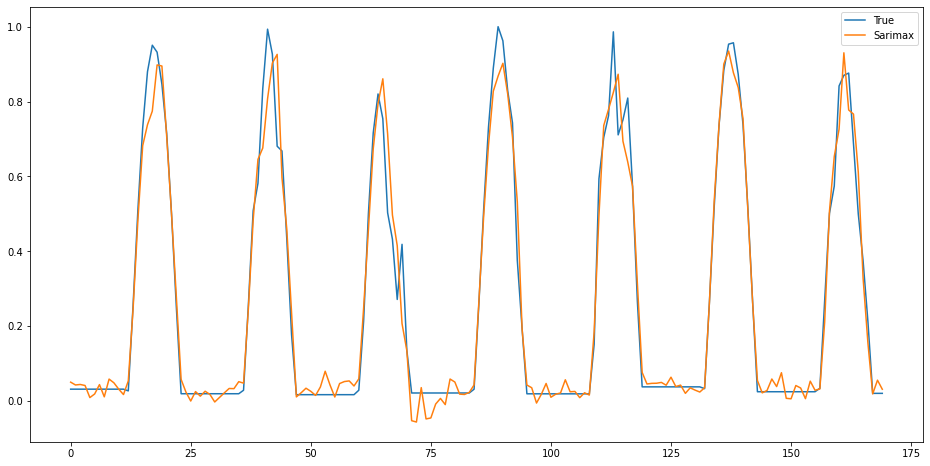

In [12]:
dict_gen_ysarimax = pickle.load(open('resultados/dict_gen_ysarimax.pckl', 'rb'))

gen = dict_gen_ysarimax['generation']
y_sarimax = dict_gen_ysarimax['y_sarimax']
data_inicial = dict_gen_ysarimax['data_inicial']

plt.figure(figsize=(16,8))
plt.plot(gen[-170:], label="True")
plt.plot(y_sarimax[-170:], label="Sarimax")
plt.legend()

# Algoritmo AGMLPResidual

In [13]:
tr_ts_percents=[80,20]

In [22]:
ag_mlp_residual = AGMLP_Residual(gen, y_sarimax, num_epochs = 4, size_pop = 15, prob_mut=0.8,
                                 tr_ts_percents=tr_ts_percents).search_best_model()
best_mlp_residual = ag_mlp_residual._best_of_all
pickle.dump(best_mlp_residual, open('resultados/best_model_AGMLP_RESIDUAL.pckl', 'wb'))

| 3/4 [00:22<00:07,  7.59s/it]
100%|██████████| 4/4 [00:27<00:00,  6.96s/it]

100%|██████████| 4/4 [00:19<00:00,  4.99s/it]

100%|██████████| 4/4 [01:19<00:00, 19.81s/it]

100%|██████████| 4/4 [00:11<00:00,  2.94s/it]

100%|██████████| 4/4 [00:22<00:00,  5.61s/it]

100%|██████████| 4/4 [00:06<00:00,  1.50s/it]

100%|██████████| 4/4 [00:47<00:00, 12.00s/it]

100%|██████████| 4/4 [00:01<00:00,  2.25it/s]

100%|██████████| 4/4 [00:53<00:00, 13.38s/it]

100%|██████████| 4/4 [00:10<00:00,  2.56s/it]

100%|██████████| 4/4 [00:22<00:00,  5.69s/it]

100%|██████████| 4/4 [00:08<00:00,  2.16s/it]

 25%|██▌       | 1/4 [17:22<52:06, 1042.02s/it]generation: 1

100%|██████████| 4/4 [00:06<00:00,  1.58s/it]

100%|██████████| 4/4 [00:13<00:00,  3.28s/it]

100%|██████████| 4/4 [00:02<00:00,  1.93it/s]

100%|██████████| 4/4 [00:47<00:00, 11.98s/it]

100%|██████████| 4/4 [00:13<00:00,  3.47s/it]

100%|██████████| 4/4 [00:16<00:00,  4.14s/it]

100%|██████████| 4/4 [00:05<00:00,  1.32s/it]

100%|█████████

## Análise Resultados

[7, 15, 12, 8, MLPRegressor(activation='tanh', early_stopping=True,
             hidden_layer_sizes=(66, 3, 1), learning_rate='invscaling',
             max_iter=500, solver='lbfgs'), MLPRegressor(early_stopping=True, hidden_layer_sizes=(22, 44, 9), max_iter=500,
             solver='lbfgs'), 0.031054650812002642]
Teste para saber se pegou o melhor mesmo! 0.031054650812002642 == 0.031054650812002642 ?
True
Resultado Dados Teste!
SARIMAX
MAE:  0.0311518818849064
MSE:  0.002527930260229751
MAPE:  0.34858466479696903
HIBRIDO
MAE:  0.031054650812002642
MSE:  0.003046259939783712
MAPE:  0.19175864064979317
GANHO MAE:
0.003121194195040533
GANHO MSE:
-0.2050411309633411
GANHO MAPE:
0.4498936413009397


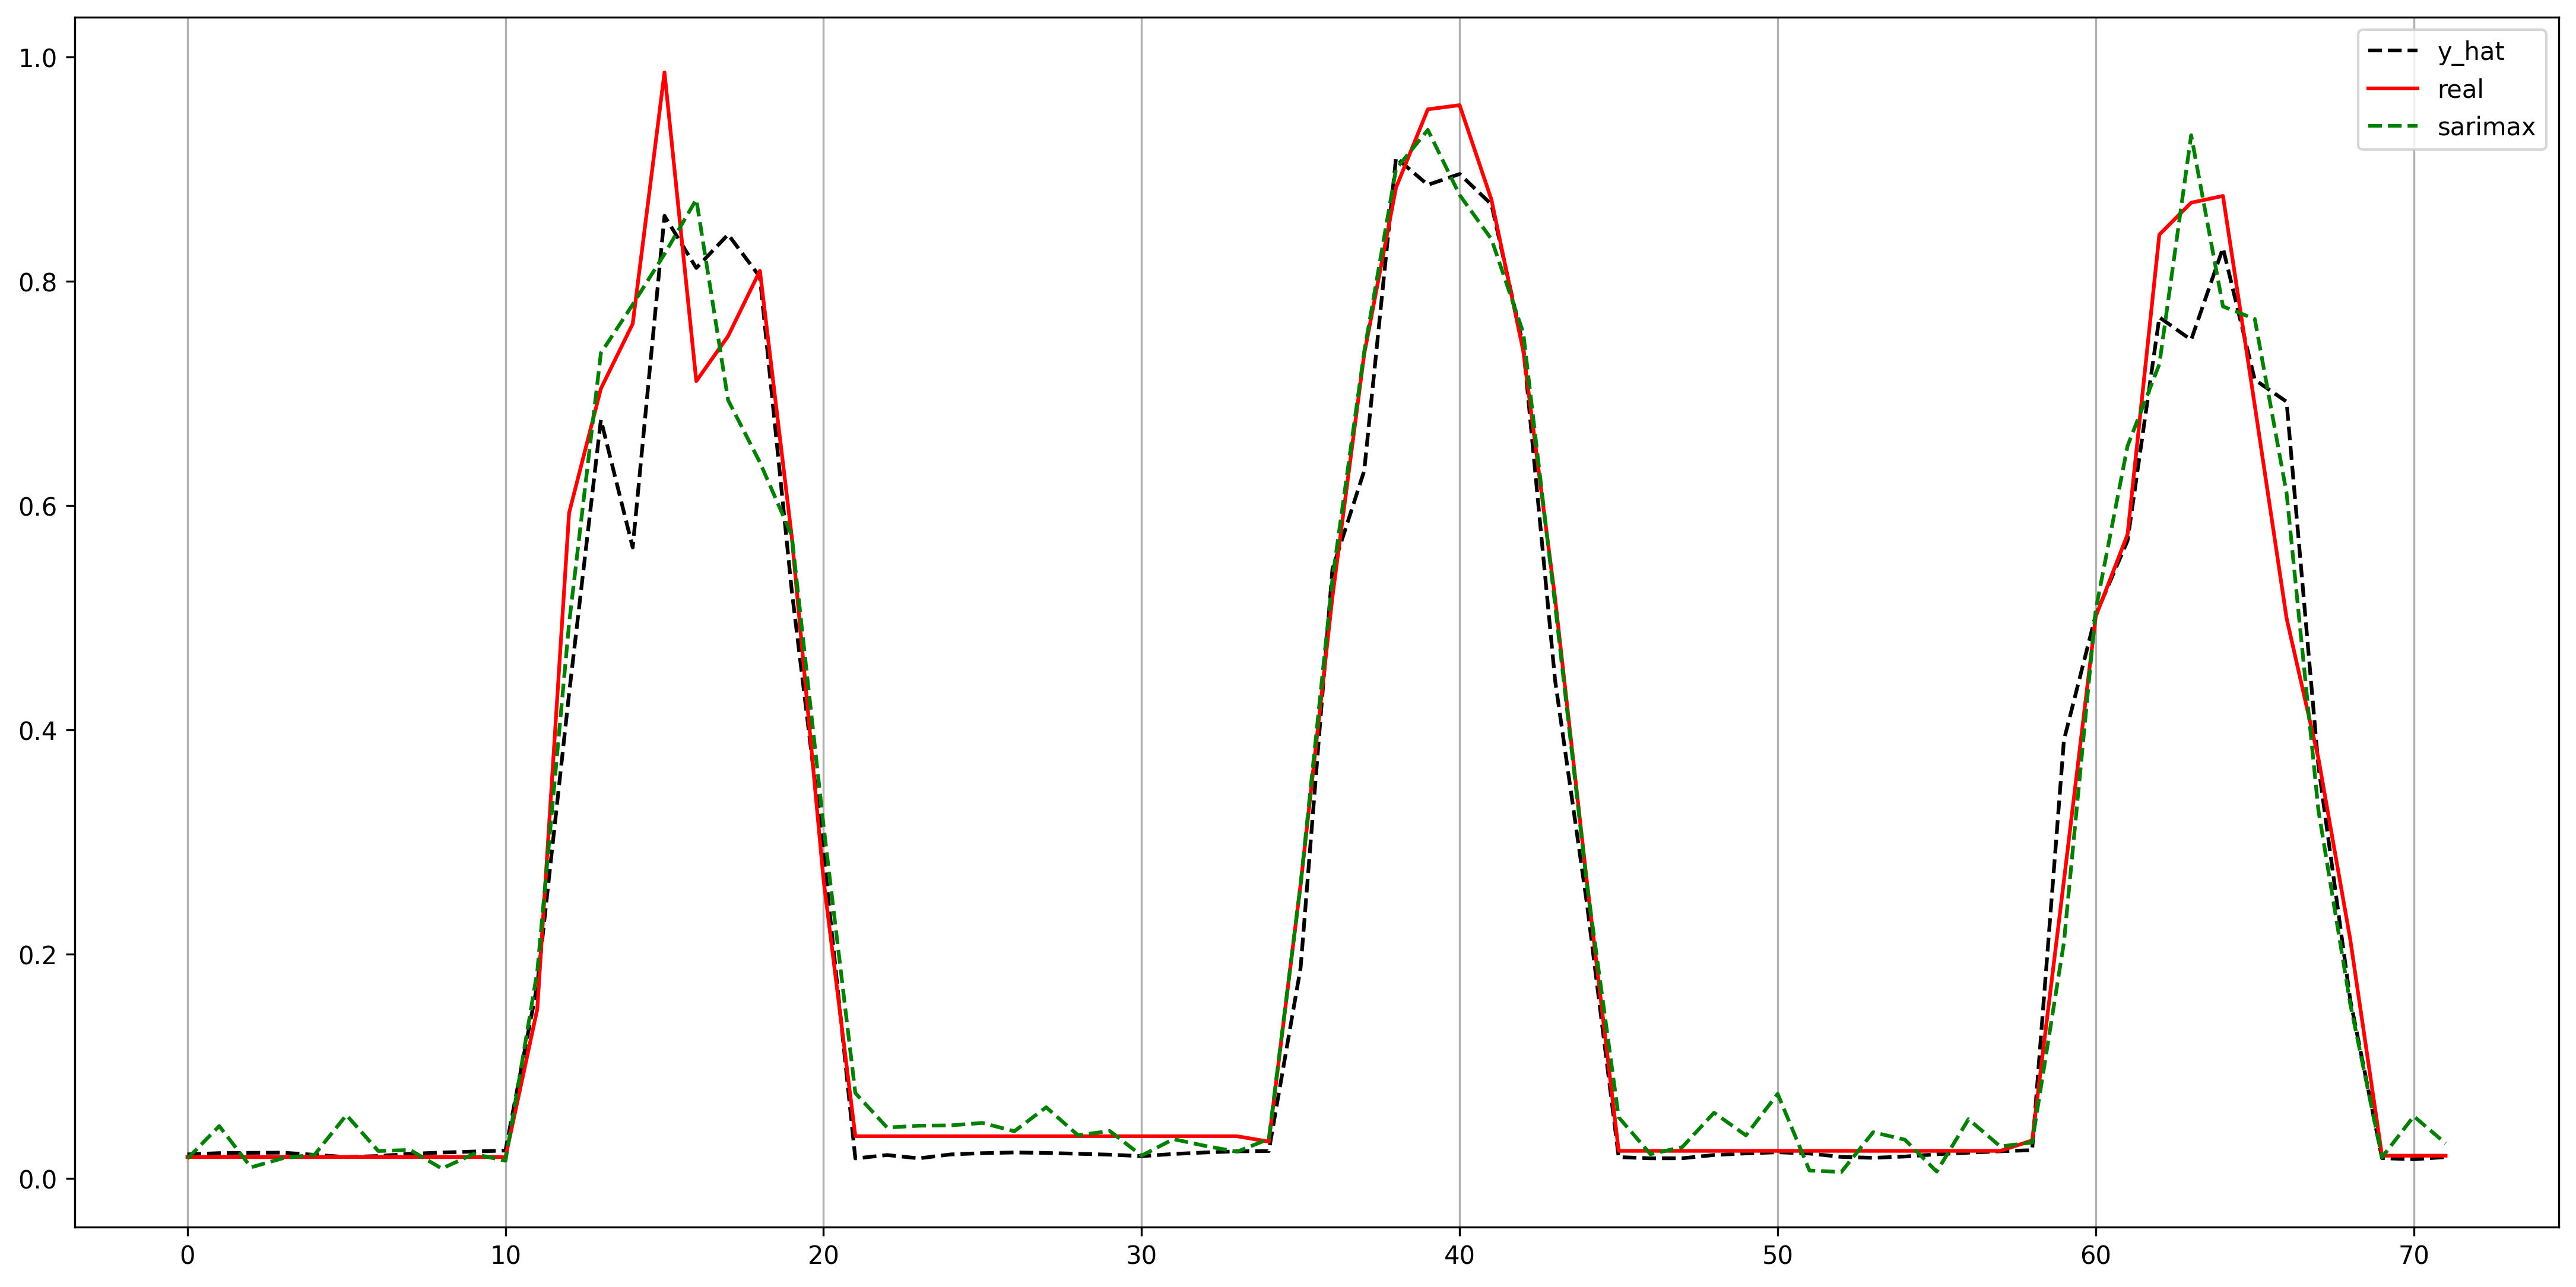

In [23]:
dict_series = pickle.load(open('resultados/dict_gen_ysarimax.pckl', 'rb'))
MaxAbsScaler_gen = pickle.load(open('resultados/MaxAbsScaler_gen.pckl', 'rb'))
# best_mlp_residual = pickle.load(open('resultados/best_model_AGMLP_RESIDUAL.pckl', 'rb'))

gen = dict_series['generation']
y_sarimax = dict_series['y_sarimax']

erro = gen - y_sarimax

data_train = gen[0:int(len(y_sarimax)*tr_ts_percents[0]/100)]
data_test = gen[int(len(y_sarimax)*tr_ts_percents[0]/100):]

erro_train_entrada, erro_train_saida, erro_test_entrada, erro_test_saida = train_test_split(erro, best_mlp_residual[0],
                                                                                            tr_ts_percents)
erro_estimado = np.concatenate((best_mlp_residual[4].predict(erro_train_entrada),
                                best_mlp_residual[4].predict(erro_test_entrada)))

X_ass_1_train_in, _, X_ass_1_test_in, _ = train_test_split(y_sarimax, best_mlp_residual[1], tr_ts_percents)
X_ass_2_train_in, _, X_ass_2_test_in, _ = train_test_split_prev(erro_estimado, best_mlp_residual[2],
                                                                best_mlp_residual[3], tr_ts_percents)

X_in_train = np.concatenate((X_ass_1_train_in, X_ass_2_train_in), axis=1)
X_in_test = np.concatenate((X_ass_1_test_in, X_ass_2_test_in), axis=1) 

y_estimado_all = np.concatenate([best_mlp_residual[5].predict(X_in_train), best_mlp_residual[5].predict(X_in_test)])
y_estimado_all_residual = y_estimado_all
y_estimado_so_test = best_mlp_residual[5].predict(X_in_test)

len_dt = len(data_test)

print(best_mlp_residual)
print("Teste para saber se pegou o melhor mesmo! {} == {} ?".format(mae(y_estimado_so_test,
                                                                        data_test),best_mlp_residual[6]))
print (mae(y_estimado_so_test, data_test) ==  best_mlp_residual[6])

print('Resultado Dados Teste!')
print('SARIMAX')
print('MAE: ', mae(y_sarimax[-len_dt:], data_test[-len_dt:]))
print('MSE: ', mse(y_sarimax[-len_dt:], data_test[-len_dt:]))
print('MAPE: ', MAPE(y_sarimax[-len_dt:], data_test[-len_dt:]))
print('HIBRIDO')
print('MAE: ', mae(y_estimado_so_test[-len_dt:], data_test[-len_dt:]))
print('MSE: ', mse(y_estimado_so_test[-len_dt:], data_test[-len_dt:]))
print('MAPE: ', MAPE(y_estimado_so_test[-len_dt:], data_test[-len_dt:]))

print ('GANHO MAE:')
print (1-mae(y_estimado_so_test, data_test[-len_dt:])/mae(y_sarimax[-len_dt:], data_test[-len_dt:]))
print ('GANHO MSE:')
print (1-mse(y_estimado_so_test, data_test[-len_dt:])/mse(y_sarimax[-len_dt:], data_test[-len_dt:]))
print ('GANHO MAPE:')
print (1-MAPE(y_estimado_so_test, data_test[-len_dt:])/MAPE(y_sarimax[-len_dt:], data_test[-len_dt:]))

len_dsh = int(len_dt)

plt.figure(figsize=(18,9), dpi=300)
plt.plot(y_estimado_all[-len_dsh:], 'k--', label='y_hat')
plt.plot(gen[-len_dsh:], 'r', label='real')
plt.plot(y_sarimax[-len_dsh:], 'g--', label='sarimax')
plt.grid(axis='x')
plt.legend()

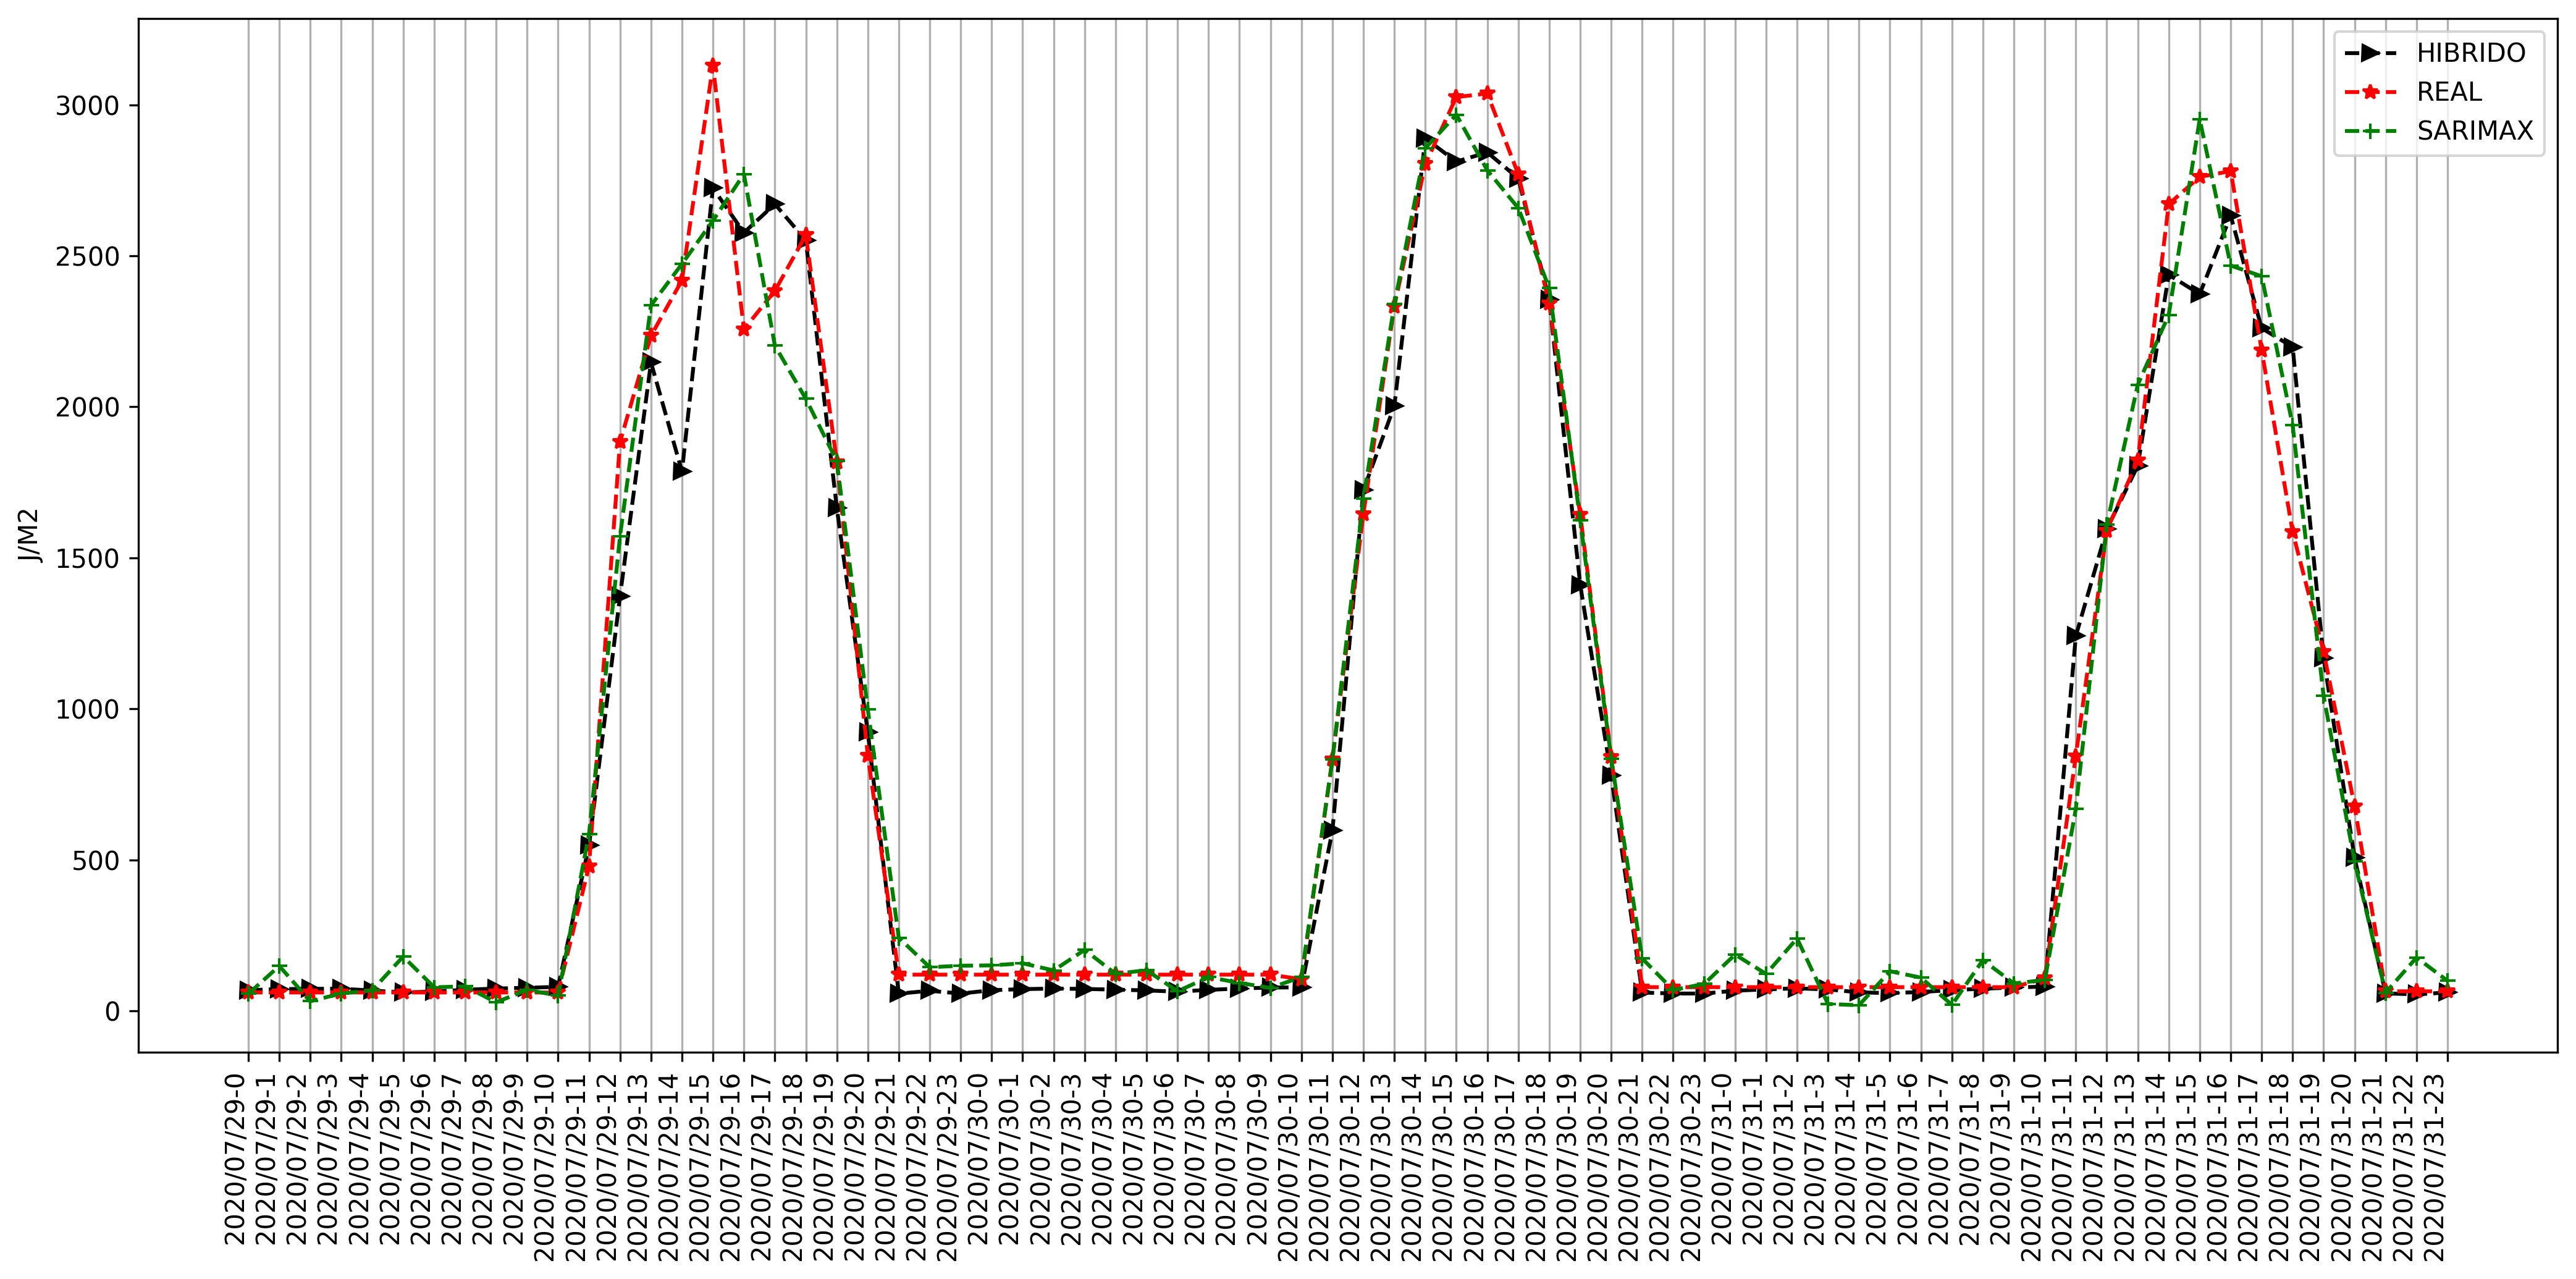

In [24]:
fig, ax = plt.subplots(1,1, figsize=(14,7), dpi=300)

last_hours = 3*24

ticks_X = df_inmet.data.astype('str') + '-' + df_inmet.hora.astype('str')
ticks_X = ticks_X[-last_hours:]
        # [np.datetime64(np.datetime_as_string(
        #x, timezone='local')[:10]).astype('str') for x in df_inmet.data[-len(data_test):].values]

ax.plot(ticks_X, MaxAbsScaler_gen.inverse_transform(y_estimado_all[-last_hours:].reshape(-1, 1)), 'k-->', label='HIBRIDO')
ax.plot(ticks_X, MaxAbsScaler_gen.inverse_transform(gen[-last_hours:].reshape(-1, 1)), 'r--*', label='REAL')
ax.plot(ticks_X, MaxAbsScaler_gen.inverse_transform(y_sarimax[-last_hours:].reshape(-1, 1)), 'g--+', label='SARIMAX')
plt.xticks(ticks_X, rotation=90, ha='right', fontsize=10)
ax.grid(axis='x')
    
ax.legend(fontsize=10)
ax.set_ylabel('W/m2', fontsize=10)
plt.tight_layout()
plt.savefig('resultados/maceio_agmlpresidual_epoch4_pop15.png', dpi=300)

# Algoritmo AGMLP_VR_Residual

In [25]:
tr_ts_percents=[80,20]
ag_mlp_vr_residual = AGMLP_VR_Residual(gen, y_sarimax, num_epochs = 4, size_pop = 15,
                                       prob_mut=0.2, tr_ts_percents=tr_ts_percents).search_best_model()

best_mlp_vr_residual = ag_mlp_vr_residual._best_of_all

pickle.dump(best_mlp_vr_residual, open('resultados/best_model_AGMLP_VR_RESIDUAL.pckl', 'wb'))

0/4 [00:00<?, ?it/s]
100%|██████████| 4/4 [00:07<00:00,  1.87s/it]

100%|██████████| 4/4 [00:21<00:00,  5.34s/it]

100%|██████████| 4/4 [00:08<00:00,  2.16s/it]

100%|██████████| 4/4 [00:32<00:00,  8.11s/it]

100%|██████████| 4/4 [00:15<00:00,  3.80s/it]

100%|██████████| 4/4 [00:15<00:00,  3.94s/it]

100%|██████████| 4/4 [00:19<00:00,  4.98s/it]

100%|██████████| 4/4 [00:21<00:00,  5.45s/it]

100%|██████████| 4/4 [00:10<00:00,  2.69s/it]

100%|██████████| 4/4 [00:26<00:00,  6.57s/it]

100%|██████████| 4/4 [00:14<00:00,  3.57s/it]

 25%|██▌       | 1/4 [13:21<40:05, 801.89s/it]generation: 1
start_set_fit: 1

100%|██████████| 4/4 [00:18<00:00,  4.56s/it]

100%|██████████| 4/4 [00:33<00:00,  8.25s/it]

100%|██████████| 4/4 [00:05<00:00,  1.38s/it]

100%|██████████| 4/4 [00:30<00:00,  7.55s/it]

100%|██████████| 4/4 [00:17<00:00,  4.47s/it]

100%|██████████| 4/4 [00:28<00:00,  7.07s/it]

100%|██████████| 4/4 [00:31<00:00,  7.85s/it]

100%|██████████| 4/4 [00:24<00:00,  6.14s/it]

100%|███

## Análise Resultados

[3, 20, 5, 17, 11, <mlopt.AgMlp.AgMlp object at 0x0000022255F637C0>, <mlopt.AgMlp.AgMlp object at 0x00000222D0AE3C10>, 0.032241696989517794]
Teste para saber se pegou o melhor mesmo! 0.032241696989517794 == <mlopt.AgMlp.AgMlp object at 0x00000222D0AE3C10> ?
False
Resultado Dados Teste!
SARIMAX
MAE:  0.0311518818849064
MSE:  0.002527930260229751
MAPE:  0.34858466479696903
HIBRIDO
MAE:  0.032241696989517794
MSE:  0.002782641205485636
MAPE:  0.25194836125405984
GANHO MAE:
-0.03498392516502924
GANHO MSE:
-0.10075869151261152
GANHO MAPE:
0.27722477005462764


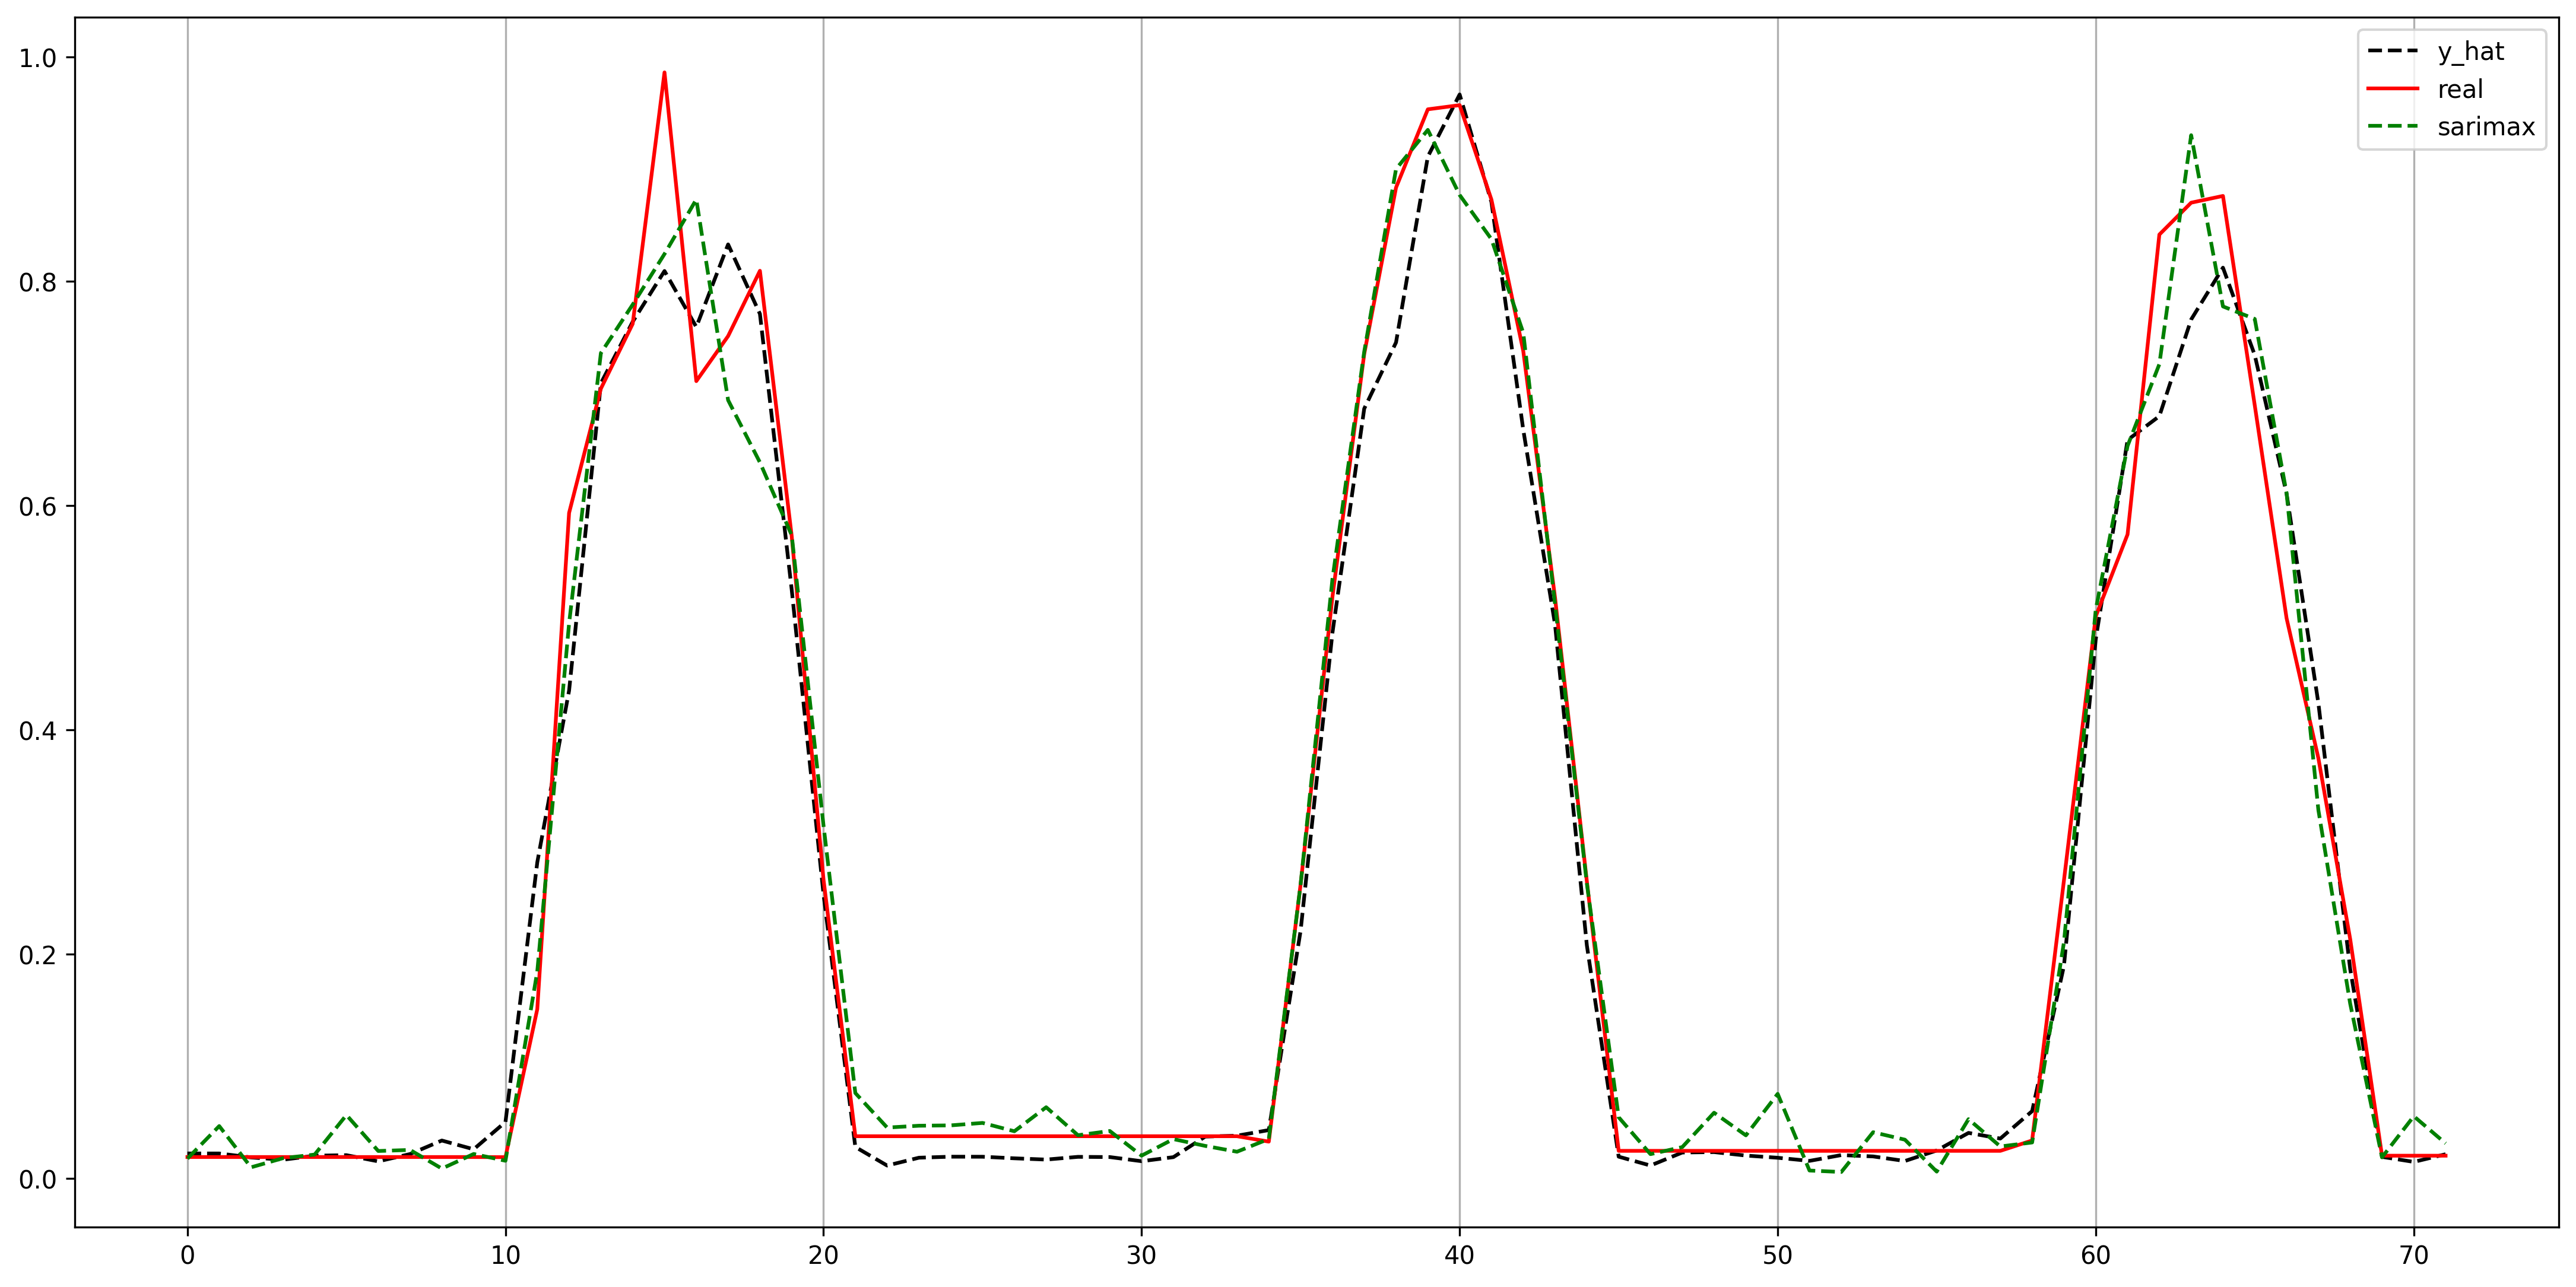

In [26]:
tr_ts_percents=[80,20]

dict_series = pickle.load(open('resultados/dict_gen_ysarimax.pckl', 'rb'))
MaxAbsScaler_gen = pickle.load(open('resultados/MaxAbsScaler_gen.pckl', 'rb'))
best = pickle.load(open('resultados/best_model_AGMLP_VR_RESIDUAL.pckl', 'rb'))

gen = dict_series['generation']
y_sarimax = dict_series['y_sarimax']

erro = gen - y_sarimax

data_train = gen[0:int(len(y_sarimax)*tr_ts_percents[0]/100)]
data_test = gen[int(len(y_sarimax)*tr_ts_percents[0]/100):]

erro_train_entrada, erro_train_saida, erro_test_entrada, erro_test_saida = train_test_split(erro, best[0], tr_ts_percents)
erro_estimado = np.concatenate((best[-3].VR_predict(erro_train_entrada), best[-3].VR_predict(erro_test_entrada)))

X_ass_1_train_in, _, X_ass_1_test_in, _ = train_test_split(y_sarimax, best[1], tr_ts_percents)
X_ass_2_train_in, _, X_ass_2_test_in, _ = train_test_split_prev(erro_estimado, best[2], best[3], tr_ts_percents)

X_in_train = np.concatenate((X_ass_1_train_in, X_ass_2_train_in), axis=1)
X_in_test = np.concatenate((X_ass_1_test_in, X_ass_2_test_in), axis=1) 

y_estimado_all = np.concatenate([best[-2].VR_predict(X_in_train), best[-2].VR_predict(X_in_test)])
y_estimado_all_vr_residual = y_estimado_all
y_estimado_so_test = best[-2].VR_predict(X_in_test)

len_dt = len(data_test)

print(best)
print("Teste para saber se pegou o melhor mesmo! {} == {} ?".format(mae(y_estimado_so_test, data_test),best[6]))
print (mae(y_estimado_so_test, data_test) ==  best[6])

print('Resultado Dados Teste!')
print('SARIMAX')
print('MAE: ', mae(y_sarimax[-len_dt:], data_test[-len_dt:]))
print('MSE: ', mse(y_sarimax[-len_dt:], data_test[-len_dt:]))
print('MAPE: ', MAPE(y_sarimax[-len_dt:], data_test[-len_dt:]))
print('HIBRIDO')
print('MAE: ', mae(y_estimado_so_test[-len_dt:], data_test[-len_dt:]))
print('MSE: ', mse(y_estimado_so_test[-len_dt:], data_test[-len_dt:]))
print('MAPE: ', MAPE(y_estimado_so_test[-len_dt:], data_test[-len_dt:]))

print ('GANHO MAE:')
print (1-mae(y_estimado_so_test, data_test[-len_dt:])/mae(y_sarimax[-len_dt:], data_test[-len_dt:]))
print ('GANHO MSE:')
print (1-mse(y_estimado_so_test, data_test[-len_dt:])/mse(y_sarimax[-len_dt:], data_test[-len_dt:]))
print ('GANHO MAPE:')
print (1-MAPE(y_estimado_so_test, data_test[-len_dt:])/MAPE(y_sarimax[-len_dt:], data_test[-len_dt:]))

len_dsh = int(len_dt)

plt.figure(figsize=(18,9), dpi=300)
plt.plot(y_estimado_all[-len_dsh:], 'k--', label='y_hat')
plt.plot(gen[-len_dsh:], 'r', label='real')
plt.plot(y_sarimax[-len_dsh:], 'g--', label='sarimax')
plt.grid(axis='x')
plt.legend()

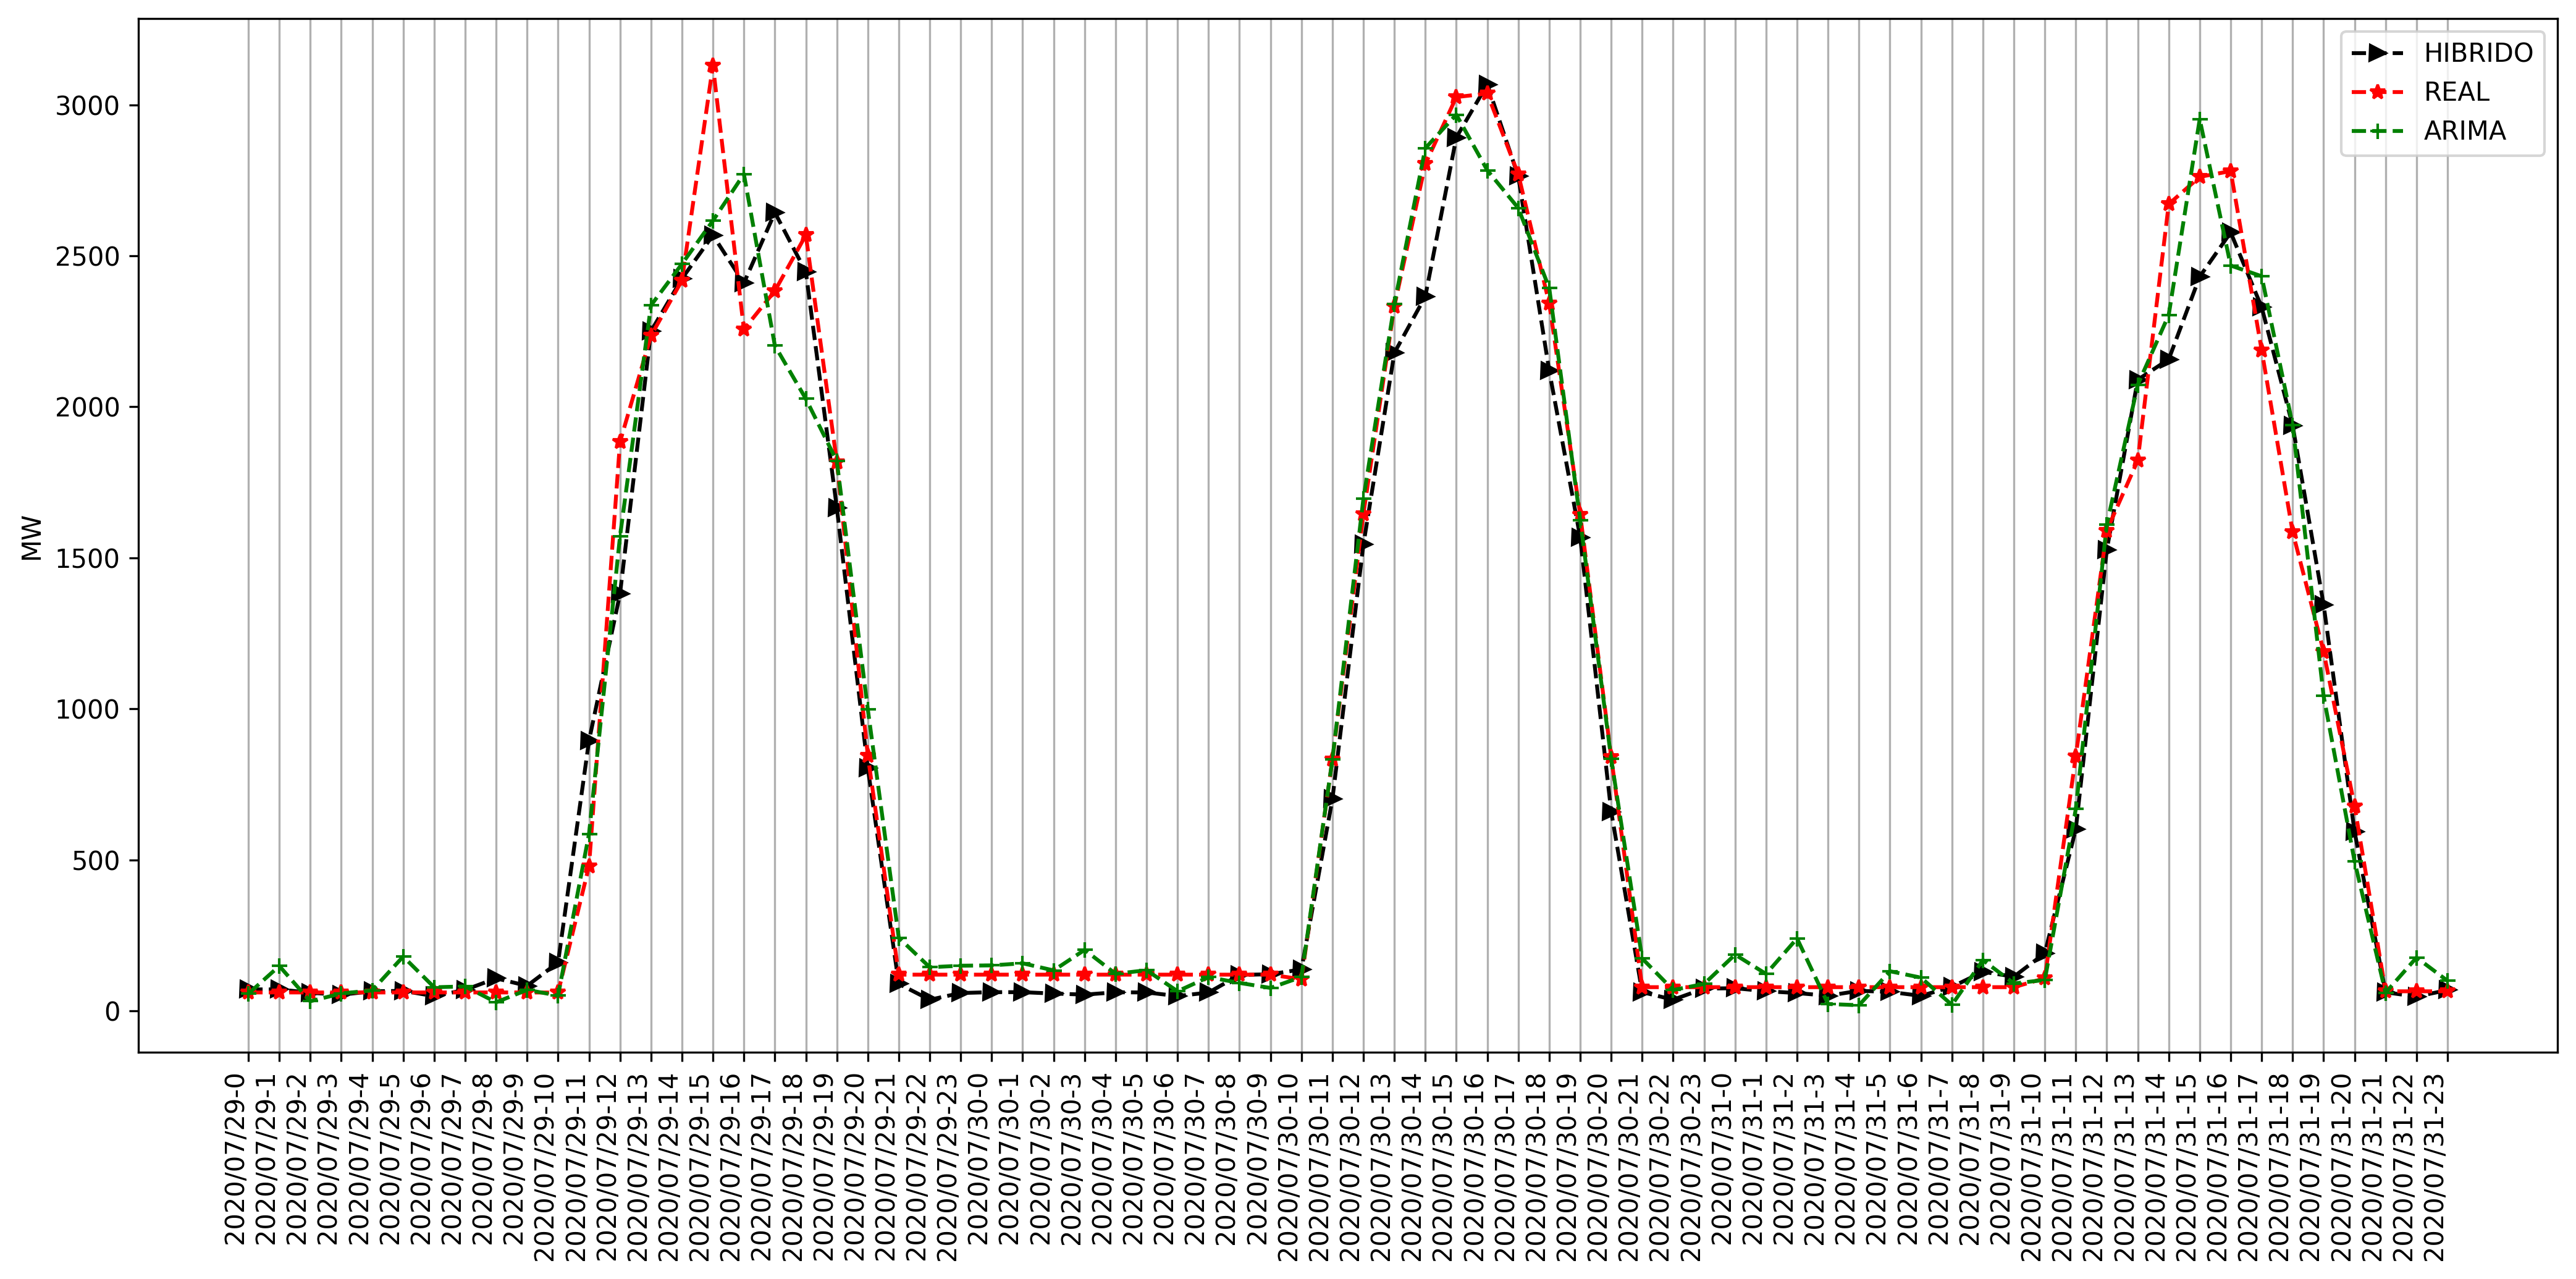

In [27]:
fig, ax = plt.subplots(1,1, figsize=(14,7), dpi=300)

last_hours = 3*24

ticks_X = df_inmet.data.astype('str') + '-' + df_inmet.hora.astype('str')
ticks_X = ticks_X[-last_hours:]
        # [np.datetime64(np.datetime_as_string(
        #x, timezone='local')[:10]).astype('str') for x in df_inmet.data[-len(data_test):].values]

ax.plot(ticks_X, MaxAbsScaler_gen.inverse_transform(y_estimado_all[-last_hours:].reshape(-1, 1)), 'k-->', label='HIBRIDO')
ax.plot(ticks_X, MaxAbsScaler_gen.inverse_transform(gen[-last_hours:].reshape(-1, 1)), 'r--*', label='REAL')
ax.plot(ticks_X, MaxAbsScaler_gen.inverse_transform(y_sarimax[-last_hours:].reshape(-1, 1)), 'g--+', label='ARIMA')
plt.xticks(ticks_X, rotation=90, ha='right', fontsize=10)
ax.grid(axis='x')
    
ax.legend(fontsize=10)
ax.set_ylabel('W/m2', fontsize=10)
plt.tight_layout()
plt.savefig('resultados/florianopolis_agmlpvrresidual_epoch4_pop15.png', dpi=300)

# Figura Unica AG-MLP/AG-MLP-VR

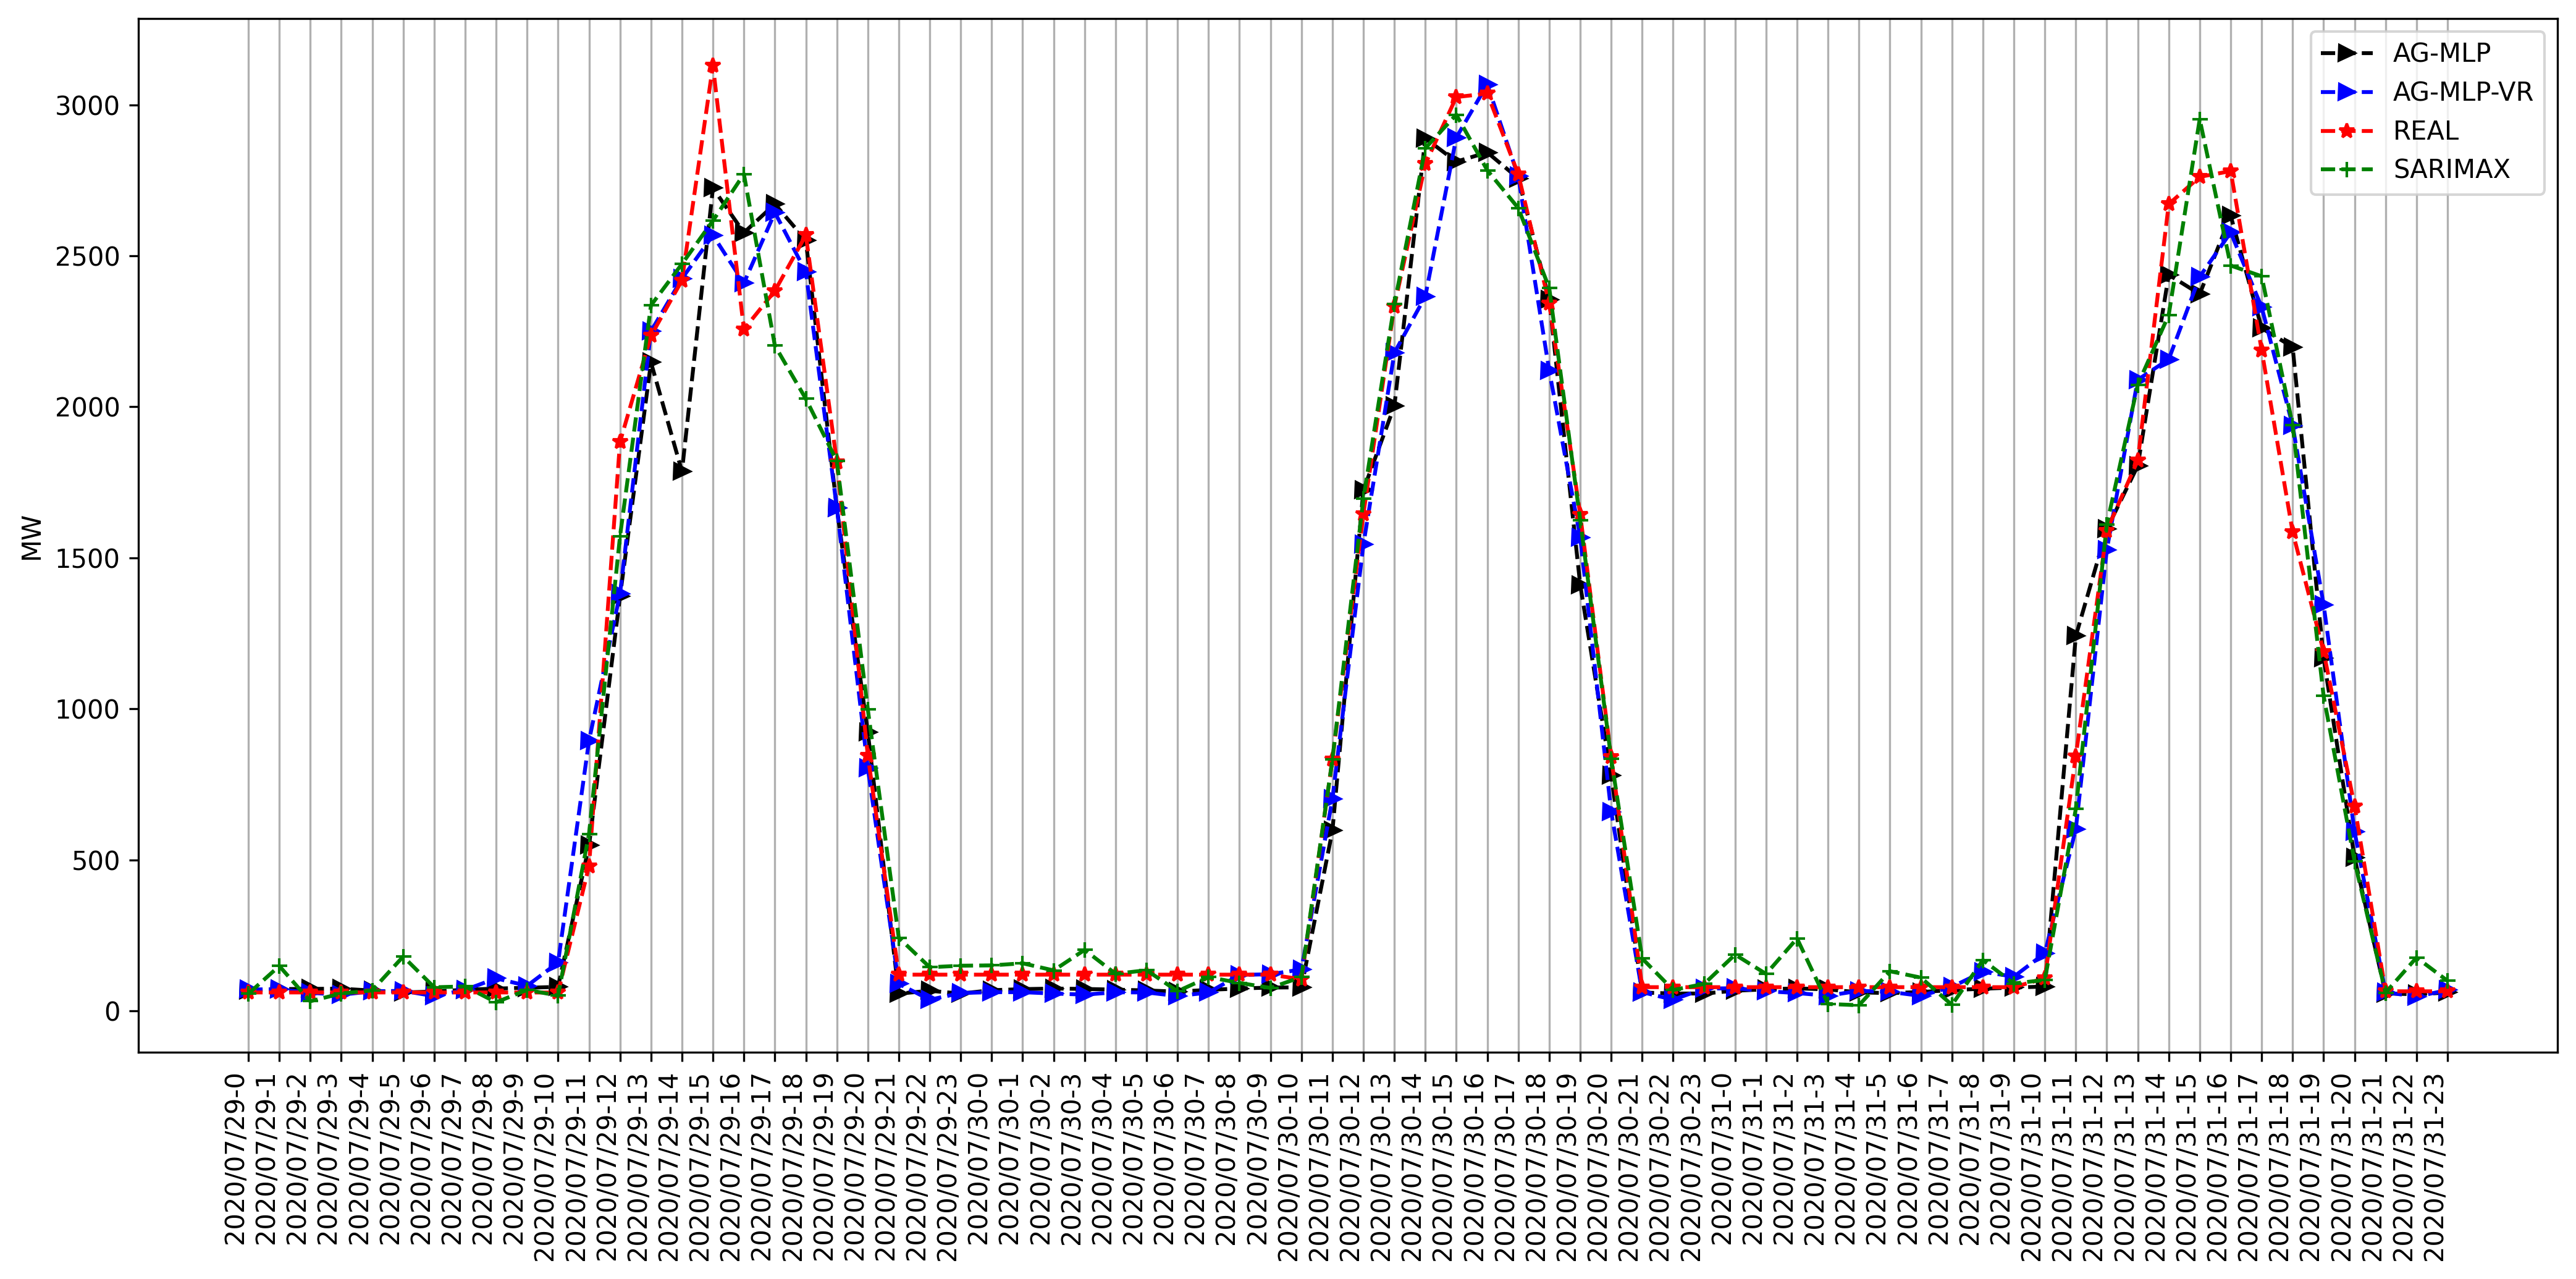

In [28]:
fig, ax = plt.subplots(1,1, figsize=(14,7), dpi=300)

last_hours = 3*24

ticks_X = df_inmet.data.astype('str') + '-' + df_inmet.hora.astype('str')
ticks_X = ticks_X[-last_hours:]
        # [np.datetime64(np.datetime_as_string(
        #x, timezone='local')[:10]).astype('str') for x in df_inmet.data[-len(data_test):].values]

ax.plot(ticks_X, MaxAbsScaler_gen.inverse_transform(y_estimado_all_residual[-last_hours:].reshape(-1, 1)), 'k-->', label='AG-MLP')
ax.plot(ticks_X, MaxAbsScaler_gen.inverse_transform(y_estimado_all_vr_residual[-last_hours:].reshape(-1, 1)), 'b-->', label='AG-MLP-VR')
ax.plot(ticks_X, MaxAbsScaler_gen.inverse_transform(gen[-last_hours:].reshape(-1, 1)), 'r--*', label='REAL')
ax.plot(ticks_X, MaxAbsScaler_gen.inverse_transform(y_sarimax[-last_hours:].reshape(-1, 1)), 'g--+', label='SARIMAX')
plt.xticks(ticks_X, rotation=90, ha='right', fontsize=10)
ax.grid(axis='x')
    
ax.legend(fontsize=10)
ax.set_ylabel('W/m2', fontsize=10)
plt.tight_layout()
plt.savefig('resultados/comparison_hibrids.png', dpi=300)

# Algoritmo AGEmsemble_Residual


[15, 10, 20, 1, VotingRegressor(estimators=[('SVR',
                             SVR(C=100, epsilon=0.1742386833465867,
                                 gamma='auto')),
                            ('BAG',
                             BaggingRegressor(max_samples=3, n_estimators=2)),
                            ('SGD', SGDRegressor()),
                            ('RFR',
                             RandomForestRegressor(max_depth=19,
                                                   min_samples_leaf=6,
                                                   min_weight_fraction_leaf=0.1315589727589142,
                                                   n_estimators=1)),
                            ('ADA', AdaBoostRegressor(n_estimators=38)),
                            ('LR', LinearRegression())]), VotingRegressor(estimators=[('RFR',
                             RandomForestRegressor(max_depth=7,
                                                   min_samples_leaf=4,
                        

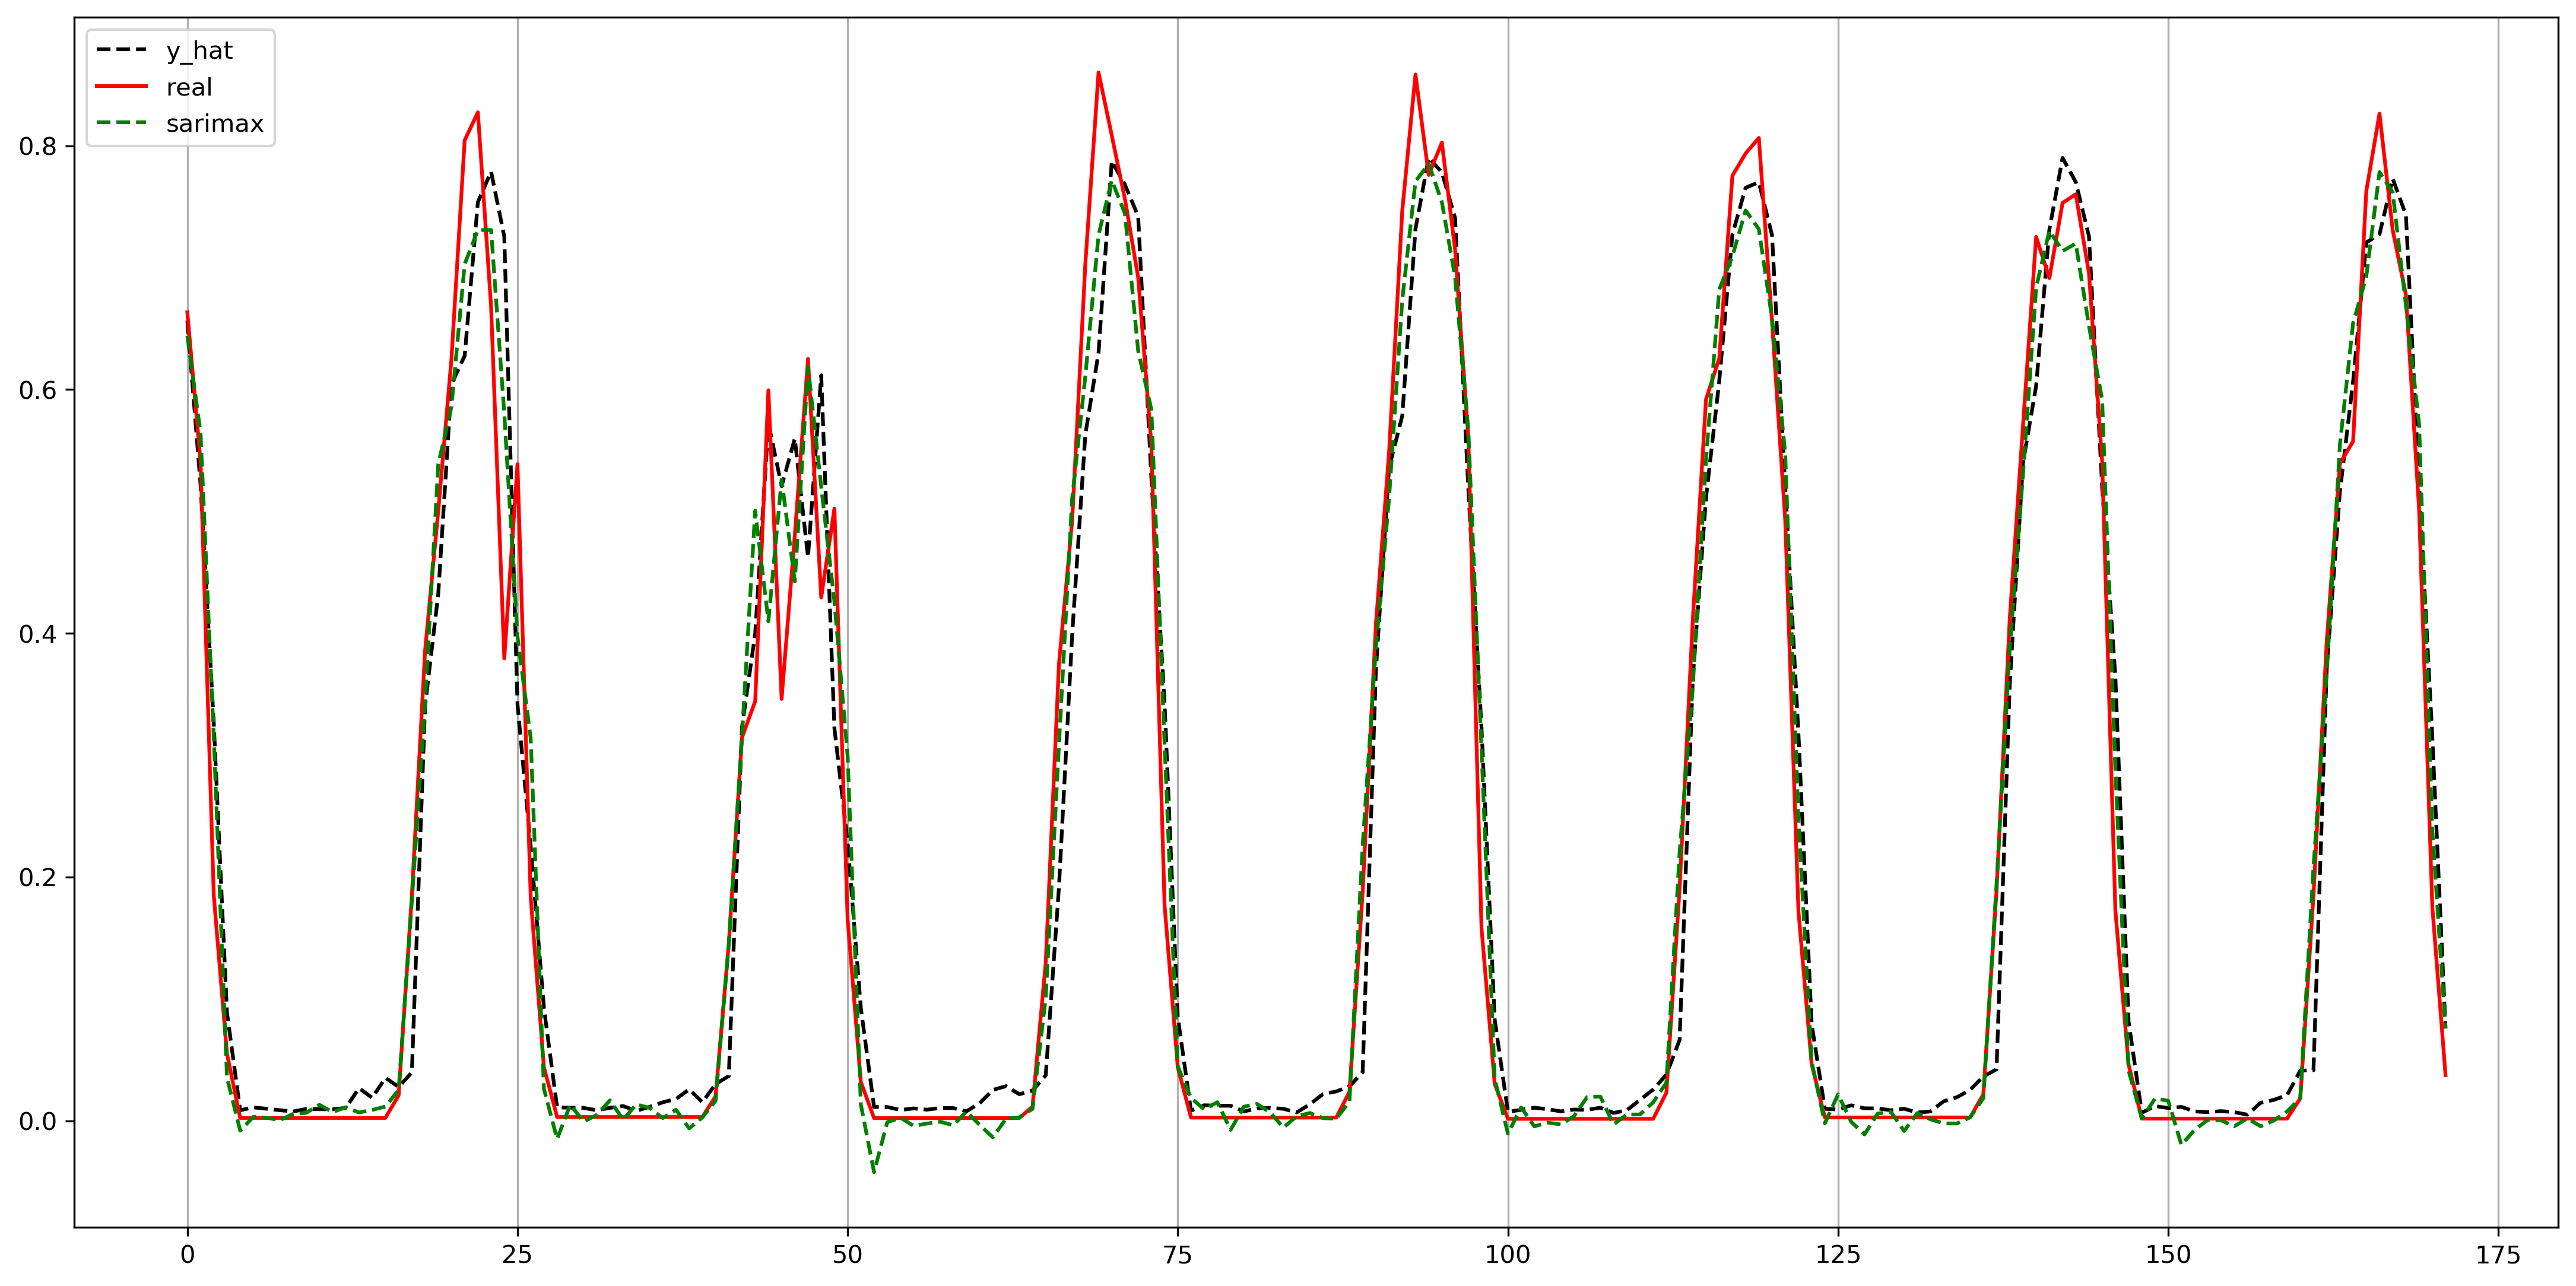

In [11]:
agensemble_residual = AGEnsemble_Residual(gen, y_sarimax, num_epochs = 3, size_pop = 10,
                                       prob_mut=0.5, tr_ts_percents=[80,20]).search_best_model()

best_agensemble_residual = agensemble_residual._best_of_all

pickle.dump(best_agensemble_residual, open('best_model_AGEmsemble_RESIDUAL.pckl', 'wb'))

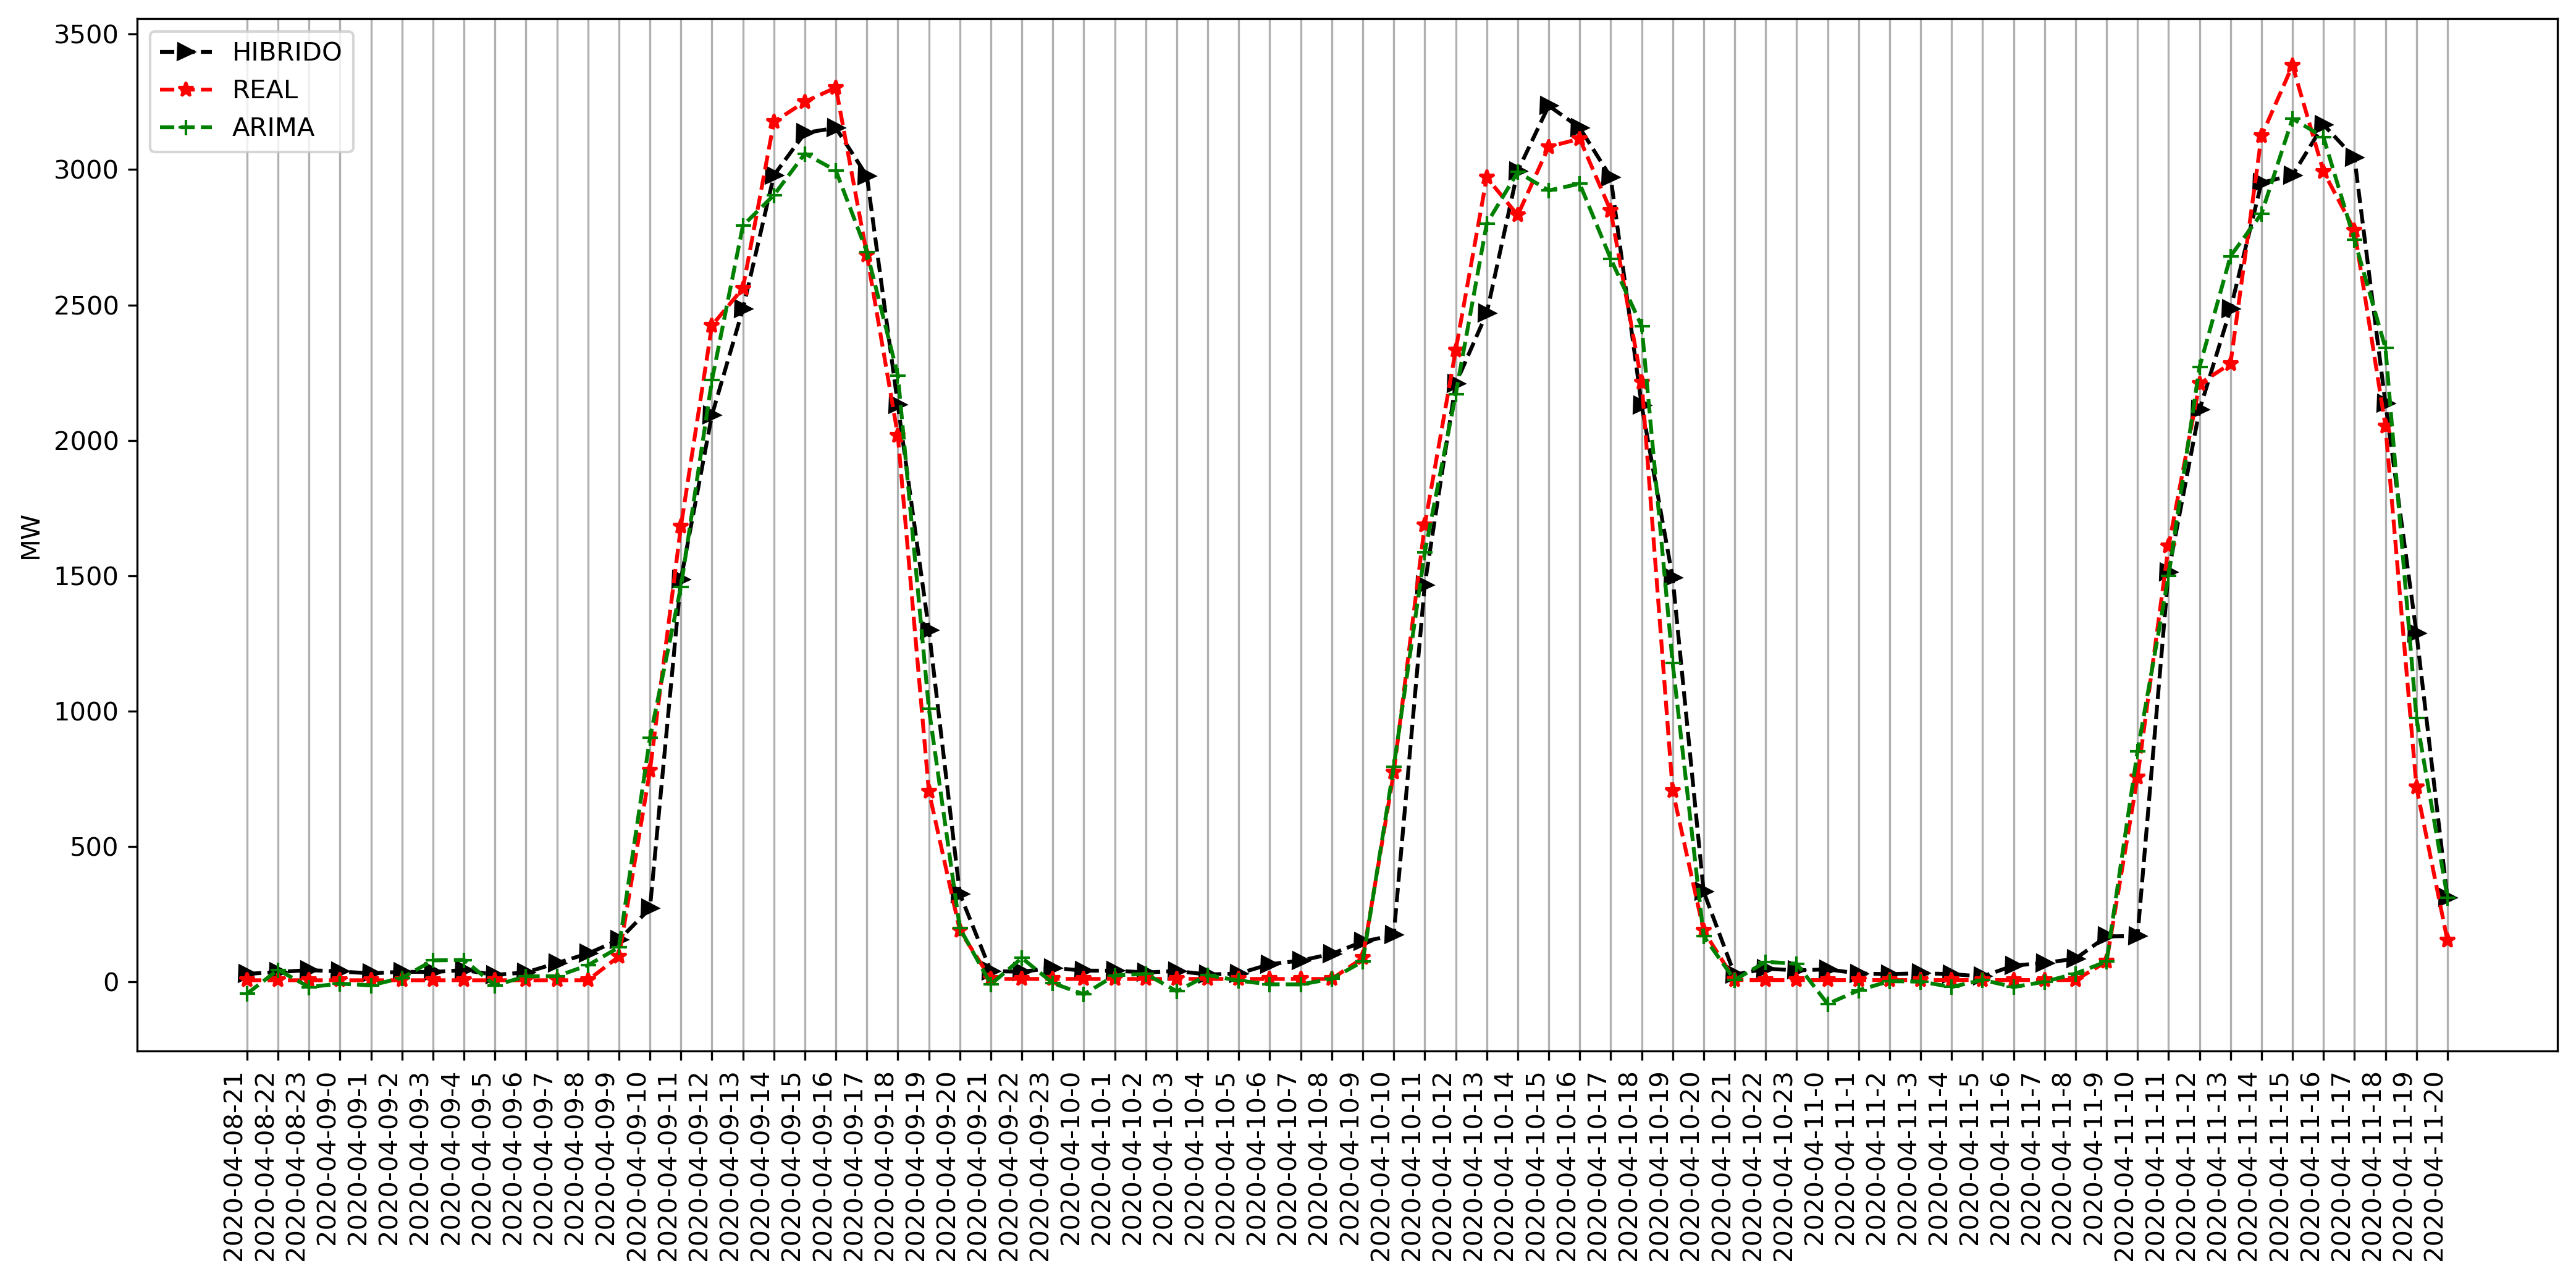

In [14]:
## Análise Resultados

In [ ]:
dict_series = pickle.load(open('dict_gen_ysarimax.pckl', 'rb'))
MaxAbsScaler_gen = pickle.load(open('MaxAbsScaler_gen.pckl', 'rb'))

gen = dict_series['generation']
y_sarimax = dict_series['y_sarimax']

best = pickle.load(open('best_model_AGEmsemble_RESIDUAL.pckl', 'rb'))

erro = gen - y_sarimax

threshold = int(len(y_sarimax)*0.8)

data_train = gen[0:threshold]
data_test = gen[threshold:]

erro_train_entrada, erro_train_saida, erro_test_entrada, erro_test_saida = train_test_split(erro, best[0], [80, 20])
erro_estimado = np.concatenate((best[4].predict(erro_train_entrada), best[4].predict(erro_test_entrada)))

X_ass_1_train_in, _, X_ass_1_test_in, _ = train_test_split(y_sarimax, best[1], [80, 20])
X_ass_2_train_in, _, X_ass_2_test_in, _ = train_test_split_prev(erro_estimado, best[2], best[3], [80, 20])

X_in_train = np.concatenate((X_ass_1_train_in, X_ass_2_train_in), axis=1)
X_in_test = np.concatenate((X_ass_1_test_in, X_ass_2_test_in), axis=1) 

y_estimado_all = np.concatenate([best[5].predict(X_in_train), best[5].predict(X_in_test)])
y_estimado_so_test = best[5].predict(X_in_test)

len_dt = len(data_test)

print(best)
print("Teste para saber se pegou o melhor mesmo! {} == {} ?".format(mae(y_estimado_so_test, data_test),best[6]))
print (mae(y_estimado_so_test, data_test) ==  best[6])

print('Resultado Dados Teste!')
print('SARIMAX')
print('MAE: ', mae(y_sarimax[-len_dt:], data_test[-len_dt:]))
print('MSE: ', mse(y_sarimax[-len_dt:], data_test[-len_dt:]))
print('MAPE: ', MAPE(y_sarimax[-len_dt:], data_test[-len_dt:]))
print('HIBRIDO')
print('MAE: ', mae(y_estimado_so_test[-len_dt:], data_test[-len_dt:]))
print('MSE: ', mse(y_estimado_so_test[-len_dt:], data_test[-len_dt:]))
print('MAPE: ', MAPE(y_estimado_so_test[-len_dt:], data_test[-len_dt:]))

print ('GANHO MAE:')
print (1-mae(y_estimado_so_test, data_test[-len_dt:])/mae(y_sarimax[-len_dt:], data_test[-len_dt:]))
print ('GANHO MSE:')
print (1-mse(y_estimado_so_test, data_test[-len_dt:])/mse(y_sarimax[-len_dt:], data_test[-len_dt:]))
print ('GANHO MAPE:')
print (1-MAPE(y_estimado_so_test, data_test[-len_dt:])/MAPE(y_sarimax[-len_dt:], data_test[-len_dt:]))

len_dsh = int(len_dt/10)

plt.figure(figsize=(18,9), dpi=300)
plt.plot(y_estimado_all[-len_dsh:], 'k--', label='y_hat')
plt.plot(gen[-len_dsh:], 'r', label='real')
plt.plot(y_sarimax[-len_dsh:], 'g--', label='sarimax')
plt.grid(axis='x')
plt.legend()